In [1]:
import os
from dotenv import load_dotenv
load_dotenv() ## aloading all the environment variable

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter


urls=[
    "https://www.microsoft.com/investor/reports/ar24/index.html/",
    "https://www.microsoft.com/en-us/investor/earnings/fy-2024-q4/segment-revenues/",
    "https://www.investopedia.com/how-microsoft-makes-money-4798809/"
]

docs=[WebBaseLoader(url).load() for url in urls]
docs


USER_AGENT environment variable not set, consider setting it to identify your requests.


[[Document(metadata={'source': 'https://www.microsoft.com/investor/reports/ar24/index.html/'}, page_content='The resource you are looking for has been removed, had its name changed, or is temporarily unavailable.')],
 [Document(metadata={'source': 'https://www.microsoft.com/en-us/investor/earnings/fy-2024-q4/segment-revenues/', 'title': 'FY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft', 'language': 'en-US'}, page_content="\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nFY24 Q4 - Segment Revenue and Operating Income - Investor Relations - Microsoft\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\t\t\t\n\n\t\t\n\t\t\n\t\t\t\tThis is the Trace Id: 3881e16e28d4026f7147a8b76cb16bf8\n\t\t\t\t\n\n\n\n\n\n\n\n\n\n\n\n\n\n \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSkip to main content\n\n\n\n\n\n\n\nMicrosoft\n\n\n\nInvestor Relations\n\n\n\n\nInvestor Relations\n\n\n\n\n     

In [3]:
doc_list=[ item for sublist in docs  for item in sublist]

text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=100)


doc_splits=text_splitter.split_documents(doc_list)

#Add all these text to vectordb

vectorstore=FAISS.from_documents(
    documents=doc_splits,
    embedding=OpenAIEmbeddings()
)
retriever=vectorstore.as_retriever()

In [4]:
retriever.invoke("Microsoft revenue 2024")

[Document(id='d356bc72-4978-4489-a303-88adff0928fe', metadata={'source': 'https://www.investopedia.com/how-microsoft-makes-money-4798809/', 'title': 'How Microsoft Makes Money', 'description': "Microsoft's is committed to responsibly designed AI. Its Intelligent Cloud segment is growing fast and is the largest source of the company's revenue and profit.", 'language': 'en'}, page_content='For the third quarter of FY 2024, revenue was $26.7 billion, an increase of 21% over the same period the previous year. In addition to the growth of revenue from Microsoft Cloud mentioned above, revenue from Azure and other cloud services grew 31%, which powered the overall revenue from server products and cloud services to a 24% growth. Operating income for the quarter was $12.5 billion, up about 32%.\n\n\n More Personal Computing\n\n\n Microsoft describes its More Personal Computing segment as consisting of products and services aimed at putting "customers at the center of the experience with our tec

In [6]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool=create_retriever_tool(
    retriever,
    "retriever_vector_db_blog",
    "Search and run information about Microsoft Revenue details"
)

In [7]:
retriever_tool

Tool(name='retriever_vector_db_blog', description='Search and run information about Microsoft Revenue details', args_schema=<class 'langchain_core.tools.retriever.RetrieverInput'>, func=functools.partial(<function _get_relevant_documents at 0x11ead9800>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x13e6a39b0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_separator='\n\n', response_format='content'), coroutine=functools.partial(<function _aget_relevant_documents at 0x11ead9940>, retriever=VectorStoreRetriever(tags=['FAISS', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x13e6a39b0>, search_kwargs={}), document_prompt=PromptTemplate(input_variables=['page_content'], input_types={}, partial_variables={}, template='{page_content}'), document_sep

In [8]:
tools=[retriever_tool]

In [9]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [10]:
from langchain_openai import ChatOpenAI
llm=ChatOpenAI(model="gpt-4o")
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_d8864f8b6b', 'id': 'chatcmpl-BSTUE3GfIaIR49iXOFkR0WRbuajPV', 'finish_reason': 'stop', 'logprobs': None}, id='run-7251448e-22f3-4a4b-af10-0069419f7385-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [11]:
def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(model="gpt-4o")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

In [12]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field

In [13]:
### Edges
def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(model="gpt-4o")

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


In [14]:
def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated message
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model="gpt-4o")

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}

In [15]:
print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  #

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [17]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(model="gpt-4o")
    response = model.invoke(msg)
    return {"messages": [response]}

In [18]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

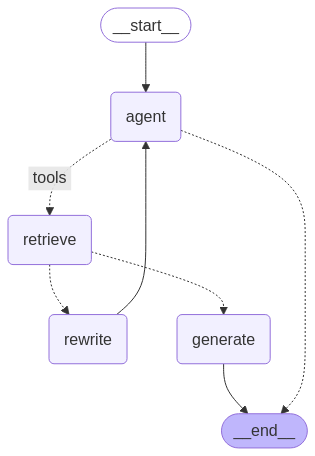

In [19]:
from IPython.display import Image, display
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [20]:
graph.invoke({"messages":"What is happening in Planet Mars"})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='What is happening in Planet Mars', additional_kwargs={}, response_metadata={}, id='3b395e27-956f-471e-81e7-0a73b7662ce8'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_99gwLtob4MLp9t8TZQWpsAdk', 'function': {'arguments': '{"query":"Planet Mars recent updates"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 64, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BSTupcC0FjtveeujcEV23VQVm9uza', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4aeedcb7-1424-4128-8b22-c8cdd5b7d2ab-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Pl

In [21]:
graph.invoke({"messages":"What are the revenue distribution of Microsoft company "})

---CALL AGENT---
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
---GENERATE---


{'messages': [HumanMessage(content='What are the revenue distribution of Microsoft company ', additional_kwargs={}, response_metadata={}, id='c8847a04-008d-4975-a85d-1d35f263b83c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GeqPvjP8oCyrwhQArw4rOQP3', 'function': {'arguments': '{"query":"Microsoft revenue distribution 2023"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 67, 'total_tokens': 91, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BSTwRgCwjaVCeZBd23Ns1b8HeoQHq', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-94c4cf52-b0bb-431a-a05d-0309fc1ee1d1-0', tool_calls=[{'name': 'retriever_vector

In [22]:
inputs={
    "messages": [
        ("user", "How Microsoft is earning money?"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_fyvOSGeGdA36ElJDbEAiT8mn', 'function': {'arguments': '{"query": "Microsoft revenue streams"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}, {'id': 'call_DAQGlf6WrJneVidppjTnE1SD', 'function': {'arguments': '{"query": "how Microsoft makes money"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 58, 'prompt_tokens': 64, 'total_tokens': 122, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BSTzZZlyGYCaieYqrC6eCFXcU7gP9', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-5e336415-6d77-466b-b2d2-c0fd135f3f69-0', tool_calls=[{'name': 'r

In [24]:
inputs={
    "messages": [
        ("user", "How  microsoft is  profit ?"),
    ]
}
for output in graph.stream(inputs):
    print(output)

---CALL AGENT---
{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_erFusWkvmzG3ieW2YQUe50Bt', 'function': {'arguments': '{"query":"Microsoft profit details"}', 'name': 'retriever_vector_db_blog'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 65, 'total_tokens': 86, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BSU20LTBgTxFxQJmqEwiUP9K3Dx8e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-27e93e9d-301c-4697-a0bb-1c6bdb6a51cf-0', tool_calls=[{'name': 'retriever_vector_db_blog', 'args': {'query': 'Microsoft profit details'}, 'id': 'call_erFusWkvmzG3ieW2YQUe50Bt', 'type': 'tool_call'}], usage_metadata={'input_tokens': 65